In [ ]:
import torch

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets

In [ ]:
MNIST_train=torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test=torchvision.datasets.MNIST('./', download = True, train = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11680096.20it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 348546.79it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3201122.82it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9270330.30it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Автокодировщик для удаления шума

In [ ]:
X_train = MNIST_train.train_data/255
X_test = MNIST_test.train_data/255

noise = 0.5 #чем выше значение, тем более зашумленные данные

X_train_noise = X_train + noise * np.random.normal(loc = 0, scale=1 ,size = X_train.shape)
X_test_noise = X_test + noise * np.random.normal(loc = 0, scale=1 ,size = X_test.shape)

X_train=X_train.to(torch.float32) #данные без шума
X_test=X_test.to(torch.float32)

X_train_noise=X_train_noise.to(torch.float32) #данные с шумом для проверки работы автокодировщика
X_test_noise=X_test_noise.to(torch.float32)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Данные с шумом мы используем для входа в сеть, а данные без шума - для оценки качества результата

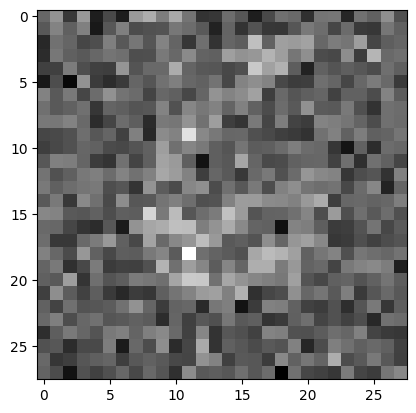

In [ ]:
plt.imshow(X_train_noise[90], cmap='gray')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, inputs, latent_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(inputs, 256)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(256, latent_size)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_size, outputs):
        super().__init__()
        self.fc1 = torch.nn.Linear(latent_size, 256)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(256, outputs)
        self.act2 = torch.nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        return x

In [ ]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
    encoder.train()
    decoder.train()
    print('Обучение автокодировщика..')

    loss_func = torch.nn.MSELoss()
    optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)
    loss_history = list()
    for epoch in range(epochs):
        for (batch, val) in data_loader:
            #batch -- это данные с шумом
            #val -- данные без шума
            optimizer.zero_grad()
            loss = loss_func(decoder(encoder(batch)), val)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.log().item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    print('Готово!')

    encoder.eval()
    decoder.eval()

    plt.plot(loss_history)
    plt.show()

In [ ]:
LATENT_SIZE = 32
EPOCHS=10
LR = 0.001
encoder = Encoder(28 * 28, LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE,  28 * 28).to(device)

In [ ]:
#сделать даталоадер, в котором будут данные с шумом для обучения и таргеты - данные без шума
class NoiseDataset(Dataset):
    def __init__(self, X_noisy, X_clean):
        self.X_noisy = X_noisy
        self.X_clean = X_clean

    def __len__(self):
        return len(self.X_noisy)

    def __getitem__(self, idx):
        return self.X_noisy[idx], self.X_clean[idx]


# Создание датасетов
X_train = X_train.reshape([-1, 28*28])
X_train_noise = X_train_noise.reshape([-1, 28*28])
train_dataset = NoiseDataset(X_train_noise.to(device), X_train.to(device))

In [ ]:
train_noise_data_loader = DataLoader(train_dataset, batch_size = 256, shuffle=True)

In [ ]:
print(encoder)
print(decoder)

Encoder(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=32, bias=True)
)
Decoder(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=784, bias=True)
  (act2): Sigmoid()
)


In [ ]:
print(f"Input size: {train_dataset[0][0].size()}")
print(f"Target size: {train_dataset[0][1].size()}")

Input size: torch.Size([784])
Target size: torch.Size([784])


Обучение автокодировщика..
Эпоха 1 / 10. Потери на последнем пакете: 0.03314712643623352
Эпоха 2 / 10. Потери на последнем пакете: 0.024140087887644768
Эпоха 3 / 10. Потери на последнем пакете: 0.023085756227374077
Эпоха 4 / 10. Потери на последнем пакете: 0.019328314810991287
Эпоха 5 / 10. Потери на последнем пакете: 0.018741900101304054
Эпоха 6 / 10. Потери на последнем пакете: 0.017481524497270584
Эпоха 7 / 10. Потери на последнем пакете: 0.015989596024155617
Эпоха 8 / 10. Потери на последнем пакете: 0.018462469801306725
Эпоха 9 / 10. Потери на последнем пакете: 0.016657056286931038
Эпоха 10 / 10. Потери на последнем пакете: 0.01653236523270607
Готово!


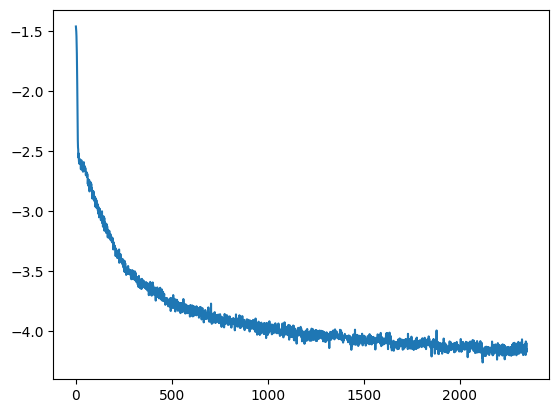

In [ ]:
EPOCHS= 10
LR= 0.001
train_ae(train_noise_data_loader, encoder, decoder, EPOCHS, LR)

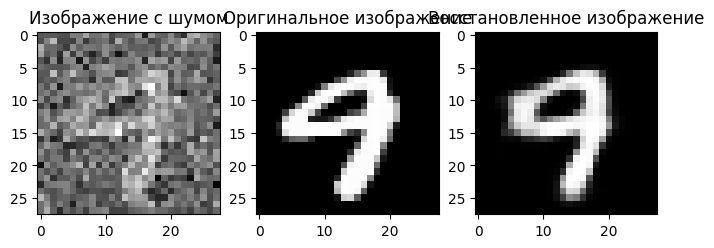

In [ ]:
# Показать результат удаления шума из данных
encoder.eval()
decoder.eval()

# Выберем случайный пример из тестового набора данных
idx = np.random.randint(0, len(X_test))
noisy_image = X_test_noise[idx].reshape(1, -1).to(device)
clean_image = X_test[idx].reshape(1, -1).to(device)

# Закодировать и декодировать изображение
latent_representation = encoder(noisy_image)
reconstructed_image = decoder(latent_representation)

# Визуализировать результаты
plt.figure(figsize=(8, 3))

plt.subplot(1, 3, 1)
plt.imshow(noisy_image.cpu().detach().squeeze().reshape(28, 28), cmap='gray')
plt.title('Изображение с шумом')

plt.subplot(1, 3, 2)
plt.imshow(clean_image.cpu().detach().squeeze().reshape(28, 28), cmap='gray')
plt.title('Оригинальное изображение')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image.cpu().detach().squeeze().reshape(28, 28), cmap='gray')
plt.title('Восстановленное изображение')

plt.show()

Вариационный автокодировщик

In [ ]:
import torch

from zipfile import ZipFile
import zipfile

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets
import torchvision.transforms as tr

In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # Input channels changed to 1
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, latent_size)  # polnosviaznyi sloi

        self.fc_mu = nn.Linear(latent_size, latent_size)  # formirovanie vektora mat ozhidanii
        self.fc_log_var = nn.Linear(latent_size, latent_size)  # formirovanie vektora logarifma dispersii

        self.latent_size = latent_size

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))  # svertochnyi sloi
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)  # flatten
        x = nn.functional.relu(self.fc1(x))  # polnosviaznyi sloi

        x = x.reshape(-1, self.latent_size)  # delaem reshape, chtoby iz svertochnogo sloia v polnosvyazku peredat' vektora

        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var  # rezul'tat enkodera -- eto vektor srednikh i vektor dispersii

    def sample_latent(self, x):  # poluchaem vektor skrytogo sostoianiia Z
        mu, log_var = self.forward(x)  # poluchaem vektora srednikh i dispersii

        # torch.randn_like(input) Vozvrashchaet tenzor sluchainykh chisel iz standartnogo normal'nogo raspredeleniia togo zhe razmera, chto i input
        N = torch.randn_like(mu).to(device)

        # dispersiia u nas vozvrashchaetsia v logarifme, a umnozhit' nam nado na standartnoe otklonenie
        # togda nuzhno /2, stepen' ukhodit i vziat' eksponentu, poluchim prosto standartnoe otklonenie
        return torch.exp(log_var / 2) * N + mu, mu, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.fc = nn.Linear(latent_size, 320)  # polnosviaznyi sloi
        self.conv1 = nn.ConvTranspose2d(20, 10, kernel_size=5)  # dekonvolutsionnyi sloi
        self.conv2 = nn.ConvTranspose2d(10, 1, kernel_size=5)  # dekonvolutsionnyi sloi
        self.latent_size = latent_size

    def forward(self, x):
        x = x.reshape(-1, self.latent_size)  # delaem reshape, chtoby iz svertochnogo sloia v polnosvyazku peredat' vektora
        x = nn.functional.relu(self.fc(x))
        x = x.view(-1, 20, 4, 4)  # reshape dlia dekonvolutsionnykh sloev
        x = nn.functional.relu(self.conv1(x))
        x = self.conv2(x)
        x = torch.sigmoid(x)  # primeniaem aktivatsiiu sigmoid, chtoby poluchit' znacheniia ot 0 do 1
        return x

In [ ]:
#import os
#import subprocess
#from google.colab import file
from google.colab import drive

#data = files.upload()

#os.chdir('')
#subprocess.run(['unzip', 'faces.zip'], check=True)
drive.mount('drive', force_remount = True)

Mounted at drive


In [ ]:
!ls /tmp/images

ls: cannot access '/tmp/images': No such file or directory


In [ ]:
# Класс нашего датасета картинок
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = tr.Compose([
            tr.ToTensor(),
            tr.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, f'image_{idx}.jpg')
        image = Image.open(image_path)
        image = self.transform(image)
        return image

In [ ]:
from torchvision.transforms import Resize
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import Resize, Compose, ToTensor

def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()

    recon_loss_func = nn.MSELoss()
    kl_loss_func = nn.KLDivLoss(reduction='batchmean')

    optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)

    loss_history = list()
    for epoch in range(epochs):
        for i, (images, _) in enumerate(data_loader):
            images = images.to(device)

            optimizer.zero_grad()

            # прямой проход через кодер и получение вектора Z, вектора средних и вектора дисперсий
            latent_vector, mu, log_sigma = encoder.sample_latent(images)

            # получение ошибки MSE
            recon_loss = recon_loss_func(decoder(latent_vector), images)

            # получение ошибки KL
            kl_loss = kl_loss_func(mu, log_sigma)
            loss = kl_loss + 1000 * recon_loss  # можно поварьировать балансировочный коэффициент

            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print('Потери восстановления:', recon_loss.item())
                print('Потери расхождения распределений:', kl_loss.item())

            loss_history.append(loss.log().item())

        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    encoder.eval()
    decoder.eval()

    print('Готово!')

    plt.plot(loss_history)
    plt.show()

In [ ]:
#dataset = pd.read_csv("/content/drive/MyDrive/faces.zip")


with ZipFile('/content/drive/MyDrive/faces.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/images')

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize

LATENT_SIZE = 32  # razmernost' skrytogo prostranstva

BATCH_SIZE = 64  # razmer paketa dannykh
EPOCHS = 5  # kolichestvo epokh obucheniia
LR = 0.001  # skorost' obucheniia

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = ImageFolder('/tmp/images', transform=Compose([
    Resize((1600, 1067)),
    ToTensor(),
    Normalize((0.5,), (0.5,))
]))

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initsiializatsiia kodir i dekodirr
encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)



'''
LATENT_SIZE = 32  # размерность скрытого пространства

BATCH_SIZE = 64  # размер пакета данных
EPOCHS = 5  # количество эпох обучения
LR = 0.001  # скорость обучения

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = ImageFolder('/tmp/images', transform=ToTensor())

#!ls /tmp/images/Humans

# Инициализация кодир и декодир
encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

# Get the first image from the dataset
img, _ = dataset[0]

# Determine the image size
IMG_SIZE = img.shape[1:]
print(f'IMG_SIZE: {IMG_SIZE}')

resize_transform = Resize((1600, 1067))

# Define the transformation pipeline
transform = Compose([
    resize_transform,
    ToTensor()
])

# Apply the transformation pipeline to the dataset
dataset = ImageFolder('/tmp/images', transform=transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Проверка что все картинки одинакового размера
#j, _ = dataset[2]
#JOPA = j.shape[1:]
#print(f'IMG_SIZE: {JOPA}')
'''

"\nLATENT_SIZE = 32  # размерность скрытого пространства\n\nBATCH_SIZE = 64  # размер пакета данных\nEPOCHS = 5  # количество эпох обучения\nLR = 0.001  # скорость обучения\n\ndevice = 'cuda' if torch.cuda.is_available() else 'cpu'\n\ndataset = ImageFolder('/tmp/images', transform=ToTensor())\n\n#!ls /tmp/images/Humans\n\n# Инициализация кодир и декодир\nencoder = Encoder(LATENT_SIZE).to(device)\ndecoder = Decoder(LATENT_SIZE).to(device)\n\n# Get the first image from the dataset\nimg, _ = dataset[0]\n\n# Determine the image size\nIMG_SIZE = img.shape[1:]\nprint(f'IMG_SIZE: {IMG_SIZE}')\n\nresize_transform = Resize((1600, 1067))\n\n# Define the transformation pipeline\ntransform = Compose([\n    resize_transform,\n    ToTensor()\n])\n\n# Apply the transformation pipeline to the dataset\ndataset = ImageFolder('/tmp/images', transform=transform)\ndata_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)\n\n# Проверка что все картинки одинакового размера\n#j, _ = dataset[2]\n#

VAE DONE

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51478661.32it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2447531.85it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14839503.82it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10042450.59it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



Epoch 1, Loss: 4002.439208984375
Epoch 2, Loss: 3599.6669921875
Epoch 3, Loss: 3662.12890625
Epoch 4, Loss: 3630.5634765625
Epoch 5, Loss: 3418.560791015625
Epoch 6, Loss: 3417.136962890625
Epoch 7, Loss: 3532.55126953125
Epoch 8, Loss: 3660.6767578125
Epoch 9, Loss: 3598.500244140625
Epoch 10, Loss: 3619.494384765625


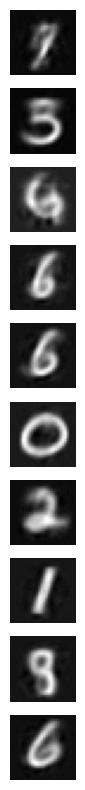

Mean of noise: tensor([ 0.2531, -0.2001], device='cuda:0')
Standard deviation of noise: tensor([0.0990, 0.1425], device='cuda:0')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
latent_dim = 2
hidden_dim = 256
learning_rate = 0.001
num_epochs = 10
num_images = 10  # Number of images to generate

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_dataset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 784)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def forward(self, x):
        x = x.view(-1, 784)
        mu, log_var = self.encoder(x).chunk(2, dim=1)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

# Initialize VAE model and optimizer
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Define loss function
def loss_function(reconstructed_x, x, mu, log_var):
    x = x.view(-1, 784)  # Reshape x to (batch_size, 784)
    reconstruction_loss = torch.sum((reconstructed_x - x)**2)
    kl_loss = 0.5 * torch.sum(torch.exp(log_var) + mu**2 - 1 - log_var)
    return reconstruction_loss + kl_loss

# Set device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae.to(device)  # Move the model to the device

# Train VAE
for epoch in range(num_epochs):
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        reconstructed_x, mu, log_var = vae(x)
        loss = loss_function(reconstructed_x, x, mu, log_var)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Generate new images
vae.eval()
with torch.no_grad():
    z = torch.randn(num_images, latent_dim).to(device)
    generated_images = vae.decoder(z)
    generated_images = generated_images.view(num_images, 28, 28)

# Display generated images
fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(1, num_images))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].cpu().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

# Recover noise from generated images
vae.eval()
with torch.no_grad():
    z = torch.randn(num_images, latent_dim).to(device)
    generated_images = vae.decoder(z)
    generated_images = generated_images.view(num_images, 28, 28)

    # Recover noise from generated images
    noise = vae.encoder(generated_images.view(-1, 784))
    mu, log_var = noise.chunk(2, dim=1)

    # Print the mean and standard deviation of the noise
    print("Mean of noise:", mu.mean(dim=0))
    print("Standard deviation of noise:", torch.exp(0.5*log_var).mean(dim=0))